In this project I will try to create machine learning model to predict if price of sp&500 will go up or down

In [129]:
#Wczytujemy potrzebne biblioteki
import pandas as pd
import numpy as np  
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

Poniżej wczytujemy dane z serwisu yahoo finance
Robimy to za pomocą biblioteki yfinance

In [54]:
sp500 = yf.Ticker('^GSPC')

sp500 = sp500.history(period='max')

<Axes: title={'center': 'S&P 500'}, xlabel='Date', ylabel='Price'>

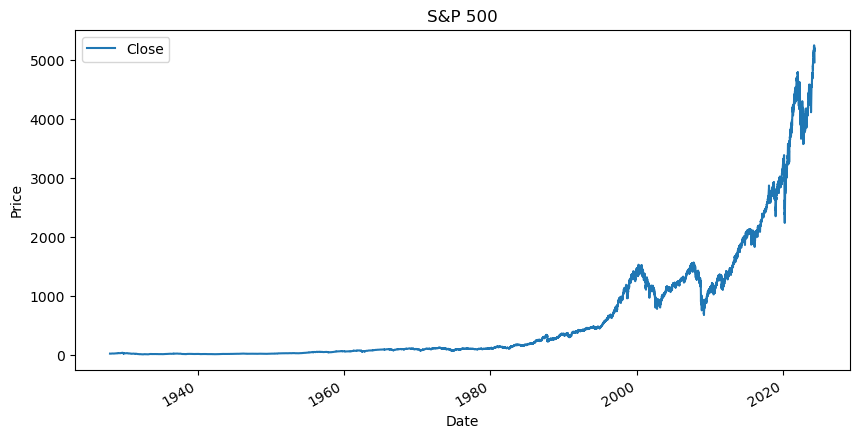

In [55]:
sp500.plot.line(y='Close', title='S&P 500', ylabel='Price', xlabel='Date', use_index=True, figsize=(10, 5))

In [56]:
# remove Dividends and Stock Splits columns
del sp500['Dividends']
del sp500['Stock Splits']   

In [57]:
#Now we are going to create new column with tomorrow's price
sp500['Tomorrow'] = sp500['Close'].shift(-1)

In [58]:
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int)

In [ ]:
#Old prices can be problematic for our model so we are going to take data since 1990
sp500 = sp500.loc['1990-01-01':].copy()

Now we are starting building and training our model

In [60]:
model = RandomForestClassifier(n_estimators=60, min_samples_split= 55, random_state=1)

In [76]:
train = sp500.iloc[:-100] #PICKING ALL DATA EXCEPT LAST 100 DAYS FOR TRAINING
test = sp500.iloc[-100:] #PICKING LAST 100 DAYS FOR TESTING

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=55, n_estimators=60, random_state=1)

In [77]:
preds = model.predict(test[predictors])

preds = pd.Series(preds, index=test.index)  

In [78]:
precision_score(test['Target'], preds)

0.6666666666666666

<Axes: xlabel='Date'>

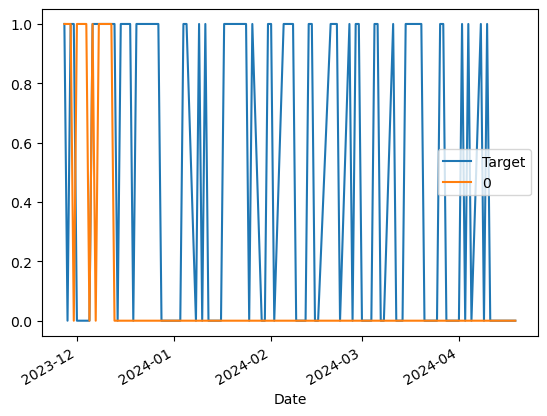

In [79]:
# 0 = our predictions
combined = pd.concat([test['Target'], preds], axis=1)

combined.plot()

BACKTESTING
creating prediction function and backtest
Backtest is sth that will evaluate our model over time

In [83]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

In [85]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [86]:
predictions = backtest(sp500, model, predictors)

In [88]:
predictions['Predictions'].value_counts()


Predictions
0    3571
1    2570
Name: count, dtype: int64

In [89]:
precision_score(predictions['Target'], predictions['Predictions']) 

0.5307392996108949

In [90]:
predictions['Target'].value_counts() / predictions.shape[0]

Target
1    0.534115
0    0.465885
Name: count, dtype: float64

Prediction score naszego modelu wynosi 53%

